# TSIA202a - Third Practice Session

The goal of this third partical work is to use an AR(p) process to model a speech signal, and show that this approch is surprisingly powerful despite its simplicity.

The proposed synthesis algorithm divides into several steps.
1. Filter the audio signal to emphasize the highest frequencies (in order to flatten the spectrum and reduce precision issues with FFT computations).
2. Split the signal into several overlapping frames and iterate over them.
    1. Detect if the frame corresponds to noise or to a voiced signal, and estimate the fundamental frequency in the later case.
    2. Estimate the AR(p) coefficients using Yule-Walker equations.
    3. Re-synthetise the frame using the AR(p) coefficients, starting from a white noise in the case of a noisy frame, or a Dirac comb in the case of a voiced frame.
3. Overlap-add the synthesized frames with a Hanning window.
4. Filter the synthesised signal to de-emphasize the highest frequencies.

We propose to implement this algorithm in two parts. First, we will derive the Yule-Walker equations, and test them on synthetic data. Then, we will code the synthesis algorithm and apply it on a real world speech signal.

# 1. Yule-Walker equations

Let us consider a causal, zero-mean, AR(p) process defined by the following recurrent equation: 
$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p}+ Z_t
$$
where $\{Z_t , t \in \mathbb{Z}\}$ is a weak white noise with variance $\sigma^2$.

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0$.
2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$.
3. We consider separately the case $h=0$: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$.
4. Put these relationships in matrix form:
\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma^2 \; 0 \; \ldots \; 0]^T
\end{equation}
ssi $\Gamma_{p+1}[1/\sigma^2 \; -\phi_1/\sigma^2 \; \ldots \; -\phi_p/\sigma^2]^T= [1 \; 0 \;\ldots \; 0]^T$\
where $\Gamma_{p+1}$ is a suitable Toeplitz matrix that you have to determine.

Q1: $E(X_{t-h}Z_t) = \phi_1 E(X_{t-h-1}Z_t) + \phi_2 E(X_{t-h-2}Z_t) + \ldots + \phi_p E(X_{t-h-p}Z_t)+ E(Z_{t-h}Z_t) $


Q2: $\gamma(h) = Cov(X_{t-h},X_t)=\phi_1 Cov(X_{t-h},X_{t-1}) + \phi_2 Cov(X_{t-h},X_{t-2}) + \ldots + \phi_p Cov(X_{t-h},X_{t-p})+ Cov(X_{t-h},Z_t) = \phi_1 \gamma(h-1) + \phi_2 \gamma(h-2) + \ldots + \phi_p \gamma(h-p)+ 0$\
\
Q3: $\gamma(0) = \phi_1 Cov(X_{t},X_{t-1}) + \phi_2 Cov(X_{t},X_{t-2}) + \ldots + \phi_p Cov(X_{t},X_{t-p})+ Cov(X_{t},Z_t) = \phi_1 \gamma(-1) + \phi_2 \gamma(-2) + \ldots + \phi_p \gamma(-p)+ \sigma^2$ \
(the $\sigma^2$ appears as a consequence of Q1 after developping $Cov(X_tZ_t) = E(X_tZ_t)$ because $Z_t$ is zero-mean)

Q4:$\Gamma_{p+1} = \begin{bmatrix} \gamma(0) & \gamma(1) & \ldots & \gamma(p) \\ \gamma(1) & \gamma(0) & \ldots & \gamma(p-1) \\ \ldots \\ \gamma(p) & \gamma(p-1) & \ldots & \gamma(0) \end{bmatrix}$

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.


In [1]:
## imports

import librosa
import soundfile as sf
import scipy
import numpy as np
import math
from collections import defaultdict
from tqdm import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML

variance =  0.9888589696438916
phi1= 0.04359182041699157
phi2= 0.08889464874632465
phi3= 0.08805174588940061
phi4= 0.12250601805617324
relative errors: 0.011141030356108361 0.5640817958300843 0.11105351253675358 0.11948254110599396 0.22506018056173235


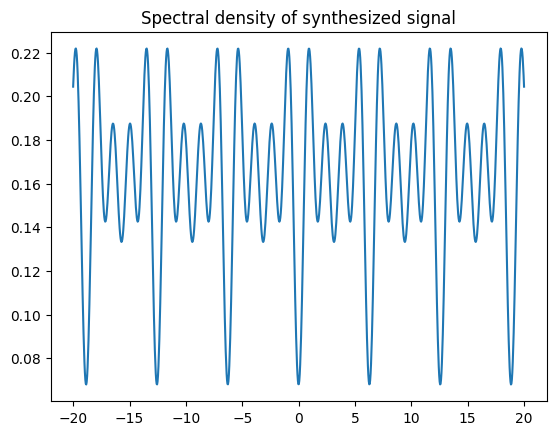

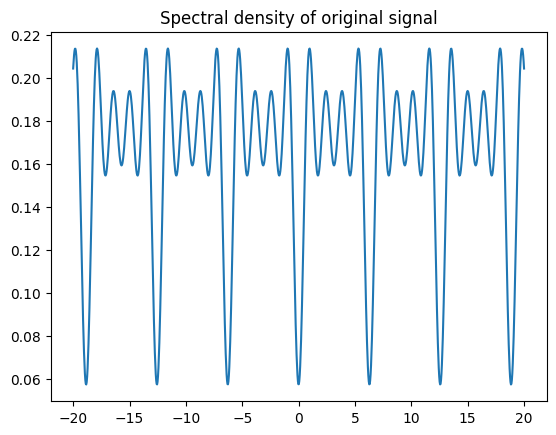

In [27]:
sigma2 = 1
n=1000
X = np.zeros(n+4)
noise = np.random.normal(0,sigma2,n)
a,b,c,d = 0.1,0.1,0.1,0.1

#Q1
for i in range(4,n+4):
    X[i]= a*X[i-1]+b*X[i-2]+c*X[i-3]+d*X[i-4]+noise[i-4]

#Q2
mean = 1/n*X.sum()
gamma_0=0
gamma_1=0
gamma_2=0
gamma_3=0
gamma_4=0
for i in range(4,n+4):
    gamma_0+=(X[i]-mean)**2
gamma_0 = 1/(n-1)*gamma_0
for i in range(5,n+4):
    gamma_1+=(X[i]-mean)*(X[i-1]-mean)
gamma_1=1/(n-2)*gamma_1
for i in range(6,n+4):
    gamma_2+=(X[i]-mean)*(X[i-2]-mean)
gamma_2 = 1/(n-3)*gamma_2
for i in range(7,n+4):
    gamma_3+=(X[i]-mean)*(X[i-3]-mean)
gamma_3=1/(n-4)*gamma_3
for i in range(8,n+4):
    gamma_4+=(X[i]-mean)*(X[i-4]-mean)
gamma_4 = 1/(n-5)*gamma_4

gamma_5 = scipy.linalg.toeplitz([gamma_0,gamma_1,gamma_2,gamma_3,gamma_4])

#Q3
estimates = np.linalg.solve(gamma_5,[1,0,0,0,0])
sig = 1/estimates[0]
phi1 = -estimates[1]*sig
phi2 = -estimates[2]*sig
phi3 = -estimates[3]*sig
phi4 = -estimates[4]*sig
print("variance = ", sig)
print("phi1=", phi1)
print("phi2=", phi2)
print("phi3=", phi3)
print("phi4=", phi4)
print("relative errors:",abs(sig-sigma2)/sigma2,abs(phi1-a)/a,abs(phi2-b)/b,abs(phi3-c)/c,abs(phi4-d)/d)

#Q4
def evaluation_polynome(phi1,phi2,phi3,phi4,t):
    return 1-phi1*t-phi2*t**2-phi3*t**3-phi4*t**4

freqs= np.linspace(-20,20,1000)
spectral_density_theory = [1/(2*np.pi)*np.abs(evaluation_polynome(0.1,0.1,0.1,0.1,np.exp(1j*l)))**2 for l in freqs]
spectral_density_synthesis = [sig/(2*np.pi)*np.abs(evaluation_polynome(phi1,phi2,phi3,phi4,np.exp(1j*l)))**2 for l in freqs]

plt.plot(freqs,spectral_density_synthesis)
plt.title("Spectral density of synthesized signal")
plt.show()
plt.plot(freqs,spectral_density_theory)
plt.title("Spectral density of original signal")
plt.show()


The spectral distribution obtained after the resynthesis is similar to the original one, the spikes are located in the same place although the undulations between those spikes don't have the same amplitude nor fluctuate between the same values.

# 3. Speech modeling

We will now implement the synthesis algorithm and evaluate it on a speech signal. 

A code template is provided below. We will use the file audio.wav to test the algorithm. 


LIsten to the original and synthesized signal by using any audio player. Try to modify the pitch of the synthesised signal and listen to the result.


In [5]:
## hyperparameters

sampling_rate = 8000 # (Hz)
frame_duration = 0.04 # duration of the analysis frames (seconds)
overlap_ratio = 0.5 # overlap ratio between two consecutive analysis frames
p = 12 # AR(p) model order
f_min = 80 # minimum frequency for pitch detection (Hz)
f_max = 400 # maximum frequency for pitch detection Hz)
pitch_detection_threshold = 0.5 # threshold for pitch detection

In [23]:
## synthesis

# load audio
x = librosa.load('audio.wav', sr=sampling_rate)[0]

# pre-emphasis filtering
x = scipy.signal.lfilter([1, -0.98], [1], x)

# handy variables
n_frame = math.floor(len(x) / (sampling_rate * frame_duration * (1 - overlap_ratio))) - 1 # discard last frame
frame_length = int(sampling_rate * frame_duration)
min_period = math.floor(sampling_rate / f_max)
max_period = math.ceil(sampling_rate / f_min)
synthesis = np.zeros(len(x))
log_dict = defaultdict(list)

def evaluation_polynome(phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,phi10,phi11,phi12,t):
    return 1+phi1*t+phi2*t**2+phi3*t**3+phi4*t**4+phi5*t**5+phi6*t**6+phi7*t**7+phi8*t**8+phi9*t**9+phi10*t**10+phi11*t**11+phi12*t**12

# loop over frames
for frame_index in tqdm(range(n_frame)):

    # extract frame
    start = int(frame_index * sampling_rate * frame_duration * (1 - overlap_ratio))
    end = start + frame_length
    frame = x[start:end]
    # detect pitch
    auto_covariance = np.fft.irfft(np.abs(np.fft.rfft(frame - np.mean(frame), (2*frame_length-1)))**2 / frame_length)[:frame_length]
    pitch, max_value = auto_covariance[min_period:].argmax() + min_period, auto_covariance[min_period:].max() / auto_covariance[0]
    if (pitch > max_period) or (max_value * frame_length / (frame_length - pitch) < pitch_detection_threshold): # detect silent frame 
        pitch = 0
    
    # estimate AR(p) coefficients
    m = frame.mean()
    g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12 = 0,0,0,0,0,0,0,0,0,0,0,0,0
    for i in range(frame_length):
        g0+=(frame[i]-m)**2
        g1+=(frame[i]-m)*(frame[i-1]-m)
        g2+=(frame[i]-m)*(frame[i-2]-m)
        g3+=(frame[i]-m)*(frame[i-3]-m)
        g4+=(frame[i]-m)*(frame[i-4]-m)
        g5+=(frame[i]-m)*(frame[i-5]-m)
        g6+=(frame[i]-m)*(frame[i-6]-m)
        g7+=(frame[i]-m)*(frame[i-7]-m)
        g8+=(frame[i]-m)*(frame[i-8]-m)
        g9+=(frame[i]-m)*(frame[i-9]-m)
        g10+=(frame[i]-m)*(frame[i-10]-m)
        g11+=(frame[i]-m)*(frame[i-11]-m)
        g12+=(frame[i]-m)*(frame[i-12]-m)
    g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12 = g0/frame_length,g1/frame_length,g2/frame_length,g3/frame_length,g4/frame_length,g5/frame_length,g6/frame_length,g7/frame_length,g8/frame_length,g9/frame_length,g10/frame_length,g11/frame_length,g12/frame_length
    gamma = scipy.linalg.toeplitz([g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12])
    v = np.array([1 if k==0 else 0 for k in range(p+1)])
    coefficient = np.linalg.solve(gamma,v)
    sigma = 1/coefficient[0]
    coefficient = sigma*coefficient

    # re-synthetise frame
    if pitch == 0:
        noise = np.random.normal(0,np.sqrt(sigma),frame_length+p)
        frame_r = scipy.signal.lfilter([1], coefficient, noise)
    else:
        indices = np.arange(0,frame_length+p,pitch)
        dirac_comb = np.zeros(frame_length+p)
        for i in indices:
            dirac_comb[i] = 1
        frame_r = scipy.signal.lfilter([1], coefficient, dirac_comb)
    frame_r = frame_r[p:]
    normalization_factor = np.sqrt(sigma / np.var(frame_r))
    frame_r = normalization_factor * frame_r[:frame_length]

    # overlap-add
    synthesis[start:end] += frame_r * np.hanning(frame_length)

    # compute power spectral density (for logging purposes)
    freqs= np.linspace(-20,20,1000)
    original_psd = scipy.signal.periodogram(frame,sampling_rate)
    synthesis_psd = [sigma/(2*np.pi)*np.abs(evaluation_polynome(coefficient[1],coefficient[2],coefficient[3],coefficient[4],coefficient[5],coefficient[6],coefficient[7],coefficient[8],coefficient[9],coefficient[10],coefficient[11],coefficient[12],np.exp(1j*l)))**2 for l in freqs]

    # log
    log_dict["frame"].append(frame)
    log_dict["pitch"].append(pitch)
    log_dict["sigma"].append(sigma)
    log_dict["coefficient"].append(coefficient)
    log_dict["frame_r"].append(frame_r)
    log_dict["original_psd"].append(original_psd)
    log_dict["synthesis_psd"].append(synthesis_psd)

# de-emphasis filtering
synthesis = scipy.signal.lfilter([1], [1, -0.98], synthesis)

# log
sf.write('synthesis.wav', synthesis, sampling_rate)
log_dict["synthesis"].append(synthesis)
log_dict = {k: np.array(v) for k, v in log_dict.items()}

  0%|          | 0/279 [00:00<?, ?it/s]

100%|██████████| 279/279 [00:05<00:00, 49.65it/s]


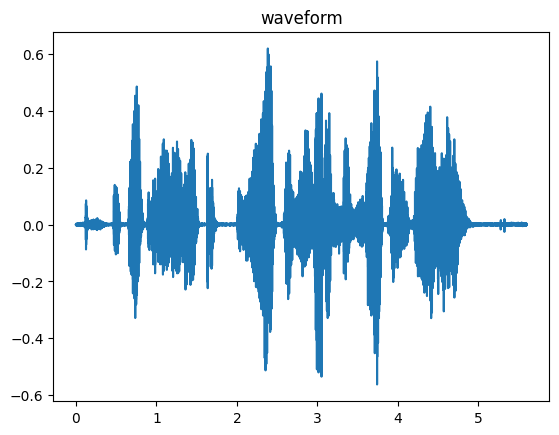

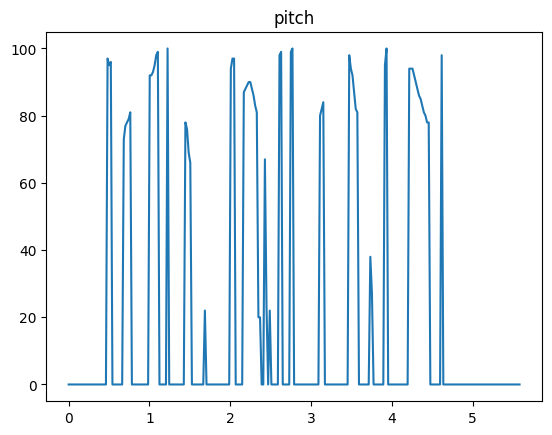

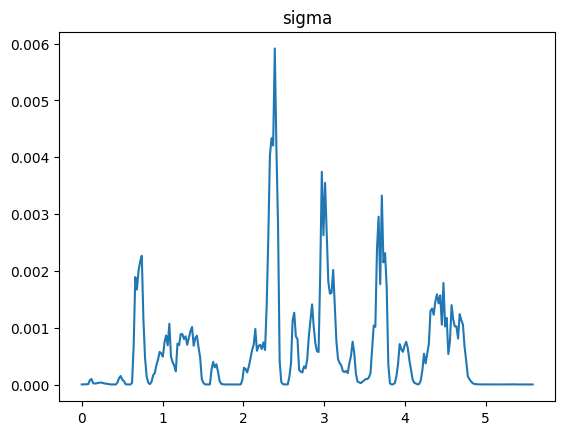

In [24]:
## plot

# time axis for plotting
sample_time = np.linspace(0, len(x)/sampling_rate, len(x))
frame_time = np.linspace(0, n_frame*frame_duration*(1-overlap_ratio), n_frame)

# waveform
plt.title("waveform")
plt.plot(sample_time, x)
plt.show()

# pitch
plt.title("pitch")
plt.plot(frame_time, log_dict["pitch"])
plt.show()

# variance
plt.title("sigma")
plt.plot(frame_time, log_dict["sigma"])
plt.show()

# power spectral density
fig, ax = plt.subplots()
fig.suptitle("estimated & theoretical spectral density")
y_min = min(log_dict["original_psd"].min(), log_dict["synthesis_psd"].min())
y_max = max(log_dict["original_psd"].max(), log_dict["synthesis_psd"].max())
def animate(i):
    ax.cla()
    ax.set_ylim([y_min-0.1, y_max+0.1])
    ax.plot(log_dict["original_psd"][i], label="original_psd")
    ax.plot(log_dict["synthesis_psd"][i], label="synthesis_psd")
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=len(log_dict["original_psd"]))
display(HTML(animation.to_jshtml()))
plt.close()